In [1]:
# Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Dict, Tuple, Optional
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])
df_vcr_c['log_monto'].describe()

df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])
df_vcr_e['log_monto'].describe()

count    25211.000000
mean         8.395828
std          0.830310
min          5.950643
25%          7.740664
50%          8.242756
75%          8.984694
max         10.915088
Name: log_monto, dtype: float64

In [3]:
df_vcr_c.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          25211 non-null  int64  
 1   monto                       25211 non-null  int64  
 2   superficie_t                25211 non-null  float64
 3   dormitorios                 25211 non-null  int64  
 4   dormitorios_faltante        25211 non-null  int64  
 5   banos                       25211 non-null  int64  
 6   banos_faltante              25211 non-null  int64  
 7   antiguedad                  25211 non-null  int64  
 8   antiguedad_faltante         25211 non-null  int64  
 9   Or_N                        25211 non-null  int64  
 10  Or_S                        25211 non-null  int64  
 11  Or_E                        25211 non-null  int64  
 12  Or_O                        25211 non-null  int64  
 13  Or_Faltante                 25211 no

In [4]:
df_vcr_e.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 197 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    id                            25211 non-null  int64  
 1    monto                         25211 non-null  int64  
 2    superficie_t                  25211 non-null  float64
 3    dormitorios                   25211 non-null  int64  
 4    dormitorios_faltante          25211 non-null  int64  
 5    banos                         25211 non-null  int64  
 6    banos_faltante                25211 non-null  int64  
 7    antiguedad                    25211 non-null  int64  
 8    antiguedad_faltante           25211 non-null  int64  
 9    Or_N                          25211 non-null  int64  
 10   Or_S                          25211 non-null  int64  
 11   Or_E                          25211 non-null  int64  
 12   Or_O                          25211 non-null  int

### Primer modelo --> Control: Modelo Hedonico ElasticNet. 
 - Dataset sin elementos georreferenciales (latitud, longitud, vcr)

In [5]:
df_ENet_1 =df_vcr_c.copy()
obj_cols = df_ENet_1.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_ENet_1 = df_ENet_1.drop(columns=cols_to_drop)
df_ENet_1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [6]:
# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2
VALID_SIZE = 0.25  # fracción del conjunto de entrenamiento que se usará para validación

# Columna objetivo
target_col = "log_monto"

# Evitar fuga: nunca usar 'monto' ni 'log_monto' como features
X = df_ENet_1.drop(columns=["monto", "log_monto"])
y = df_ENet_1[target_col].values

# Guardamos índices para reconstruir métricas en espacio de precio cuando entrenamos en log
indices = np.arange(len(df_ENet_1))
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, indices, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Split de validación a partir del train
X_train, X_valid, y_train, y_valid, idx_train, idx_valid = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=VALID_SIZE, random_state=RANDOM_STATE
)

# Definición del modelo
# Escalado es crucial para ElasticNet; CV selecciona alpha y l1_ratio.
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "enet",
            ElasticNetCV(  # Busqueda automatica de hiperparametros por validacion cruzada
                l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0],  # 1=Lasso puro, 0=Ridge puro
                cv=10,  # 10-Fold CV
                random_state=RANDOM_STATE,
                n_alphas=100,
                max_iter=10000,
                # Para cada l1_ratio se genera un camino de regularizacion con 100 valores de alpha
                # Mediante la CV se elige el mejor alpha
            ),
        ),
    ]
)
# Tras encontrar todos los hiperparametros optimos, el estimador se reentrena con TODO el conjunto 
# de entrenamiento (X_train) con esos hiperparametros.

# Entrenamiento y evaluación. Se ejecuta el pipeline anterior.
model.fit(X_train, y_train)

# ---- Predicciones (log) ----
y_pred_train_log = model.predict(X_train)
y_pred_valid_log = model.predict(X_valid)
y_pred_test_log  = model.predict(X_test)

# ---- Residuos en log (test) ----
residuals_log_test = y_test - y_pred_test_log

# ---- Métricas en LOG ----
def rmse_log(y_true_log, y_pred_log):
    return float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))

r2_log_train   = r2_score(y_train, y_pred_train_log)
r2_log_valid   = r2_score(y_valid, y_pred_valid_log)
r2_log_test    = r2_score(y_test,  y_pred_test_log)

rmse_log_train = rmse_log(y_train, y_pred_train_log)
rmse_log_valid = rmse_log(y_valid, y_pred_valid_log)
rmse_log_test  = rmse_log(y_test,  y_pred_test_log)

mae_log_train = mean_absolute_error(y_train, y_pred_train_log)
mae_log_valid = mean_absolute_error(y_valid, y_pred_valid_log)
mae_log_test  = mean_absolute_error(y_test, y_pred_test_log)

# ---- Métricas en UF (precio) ----
y_true_train_price = df_ENet_1.loc[X_train.index, "monto"].to_numpy(dtype=float)
y_true_valid_price = df_ENet_1.loc[X_valid.index, "monto"].to_numpy(dtype=float)
y_true_test_price  = df_ENet_1.loc[X_test.index,  "monto"].to_numpy(dtype=float)

# Como entrenamos en log, llevamos predicciones a UF
y_pred_train_price = np.exp(y_pred_train_log)
y_pred_valid_price = np.exp(y_pred_valid_log)
y_pred_test_price  = np.exp(y_pred_test_log)

# Chequeos de consistencia
assert np.allclose(y_train, df_ENet_1.loc[X_train.index, "log_monto"].to_numpy())
assert np.allclose(y_valid, df_ENet_1.loc[X_valid.index, "log_monto"].to_numpy())
assert np.allclose(y_test,  df_ENet_1.loc[X_test.index,  "log_monto"].to_numpy())

# Métricas en precio
rmse_train = root_mean_squared_error(y_true_train_price, y_pred_train_price)
mae_train  = mean_absolute_error(y_true_train_price, y_pred_train_price)
mape_train = np.mean(np.abs((y_true_train_price - y_pred_train_price) / np.clip(y_true_train_price, 1e-9, None))) * 100

rmse_valid = root_mean_squared_error(y_true_valid_price, y_pred_valid_price)
mae_valid  = mean_absolute_error(y_true_valid_price, y_pred_valid_price)
mape_valid = np.mean(np.abs((y_true_valid_price - y_pred_valid_price) / np.clip(y_true_valid_price, 1e-9, None))) * 100

rmse_test = root_mean_squared_error(y_true_test_price, y_pred_test_price)
mae_test  = mean_absolute_error(y_true_test_price, y_pred_test_price)
mape_test = np.mean(np.abs((y_true_test_price - y_pred_test_price) / np.clip(y_true_test_price, 1e-9, None))) * 100

print("=== ElasticNet Hedónico (control) ===")
print(">> Métricas en LOG")
print(f"Train: R^2={r2_log_train:.4f} | RMSE_log={rmse_log_train:.4f} | MAE={mae_log_train:,.4f}")
print(f"Valid: R^2={r2_log_valid:.4f} | RMSE_log={rmse_log_valid:.4f} | MAE={mae_log_valid:,.4f}")
print(f"Test : R^2={r2_log_test:.4f}  | RMSE_log={rmse_log_test:.4f} | MAE={mae_log_test:,.4f}")

print(">> Métricas en UF (precio)")
print(f"Train: RMSE={rmse_train:,.2f} | MAE={mae_train:,.2f} | MAPE={mape_train:.2f}%")
print(f"Valid: RMSE={rmse_valid:,.2f} | MAE={mae_valid:,.2f} | MAPE={mape_valid:.2f}%")
print(f"Test : RMSE={rmse_test:,.2f}  | MAE={mae_test:,.2f}  | MAPE={mape_test:.2f}%")

# Coeficientes
enet: ElasticNetCV = model.named_steps["enet"]
coef = enet.coef_
feat_names = X.columns
coef_df = (
    pd.DataFrame({"feature": feat_names, "coef": coef})
    .assign(abs_coef=lambda d: d.coef.abs())
    .sort_values("abs_coef", ascending=False)
)
print("\nTop 20 coeficientes por |coef| (estandarizados):")
print(coef_df.head(20).to_string(index=False))

# ---- Extra: resumen de CV (log) y datos para el gráfico de la curva de validación ----
enet: ElasticNetCV = model.named_steps["enet"]

# Identificar índice del mejor l1_ratio en la grilla usada
l1_candidates = np.atleast_1d(enet.l1_ratio).astype(float)
best_l1 = float(enet.l1_ratio_)
l1_idx = int(np.argmin(np.abs(l1_candidates - best_l1)))

# Paths de alphas y MSE (log) para ese l1_ratio
alphas_path = enet.alphas_[l1_idx]               # shape: (n_alphas,)
mse_path    = enet.mse_path_[l1_idx]             # shape: (n_alphas, n_folds)
mean_mse    = mse_path.mean(axis=1)
std_mse     = mse_path.std(axis=1)

# Ubicación del mejor alpha
best_alpha = float(enet.alpha_)
best_alpha_idx = int(np.argmin(np.abs(alphas_path - best_alpha)))
cv_rmse_log_best = float(np.sqrt(mean_mse[best_alpha_idx]))

print("\n>> CV (10-fold) en LOG")
print(f"l1_ratio*={best_l1} | alpha*={best_alpha:.6f} | RMSE_log_CV={cv_rmse_log_best:.4f}")

# Guardar datos para el gráfico (siguiente celda)
enet_cv_path = {
    "alphas": alphas_path,
    "mean_mse_log": mean_mse,
    "std_mse_log": std_mse,
    "best_alpha": best_alpha,
}


=== ElasticNet Hedónico (control) ===
>> Métricas en LOG
Train: R^2=0.8032 | RMSE_log=0.3664 | MAE=0.2880
Valid: R^2=0.8028 | RMSE_log=0.3711 | MAE=0.2905
Test : R^2=0.8094  | RMSE_log=0.3657 | MAE=0.2886
>> Métricas en UF (precio)
Train: RMSE=5,169.63 | MAE=2,124.53 | MAPE=30.60%
Valid: RMSE=5,185.16 | MAE=2,161.54 | MAPE=30.58%
Test : RMSE=5,008.52  | MAE=2,152.17  | MAPE=30.50%

Top 20 coeficientes por |coef| (estandarizados):
             feature      coef  abs_coef
        superficie_t  0.457518  0.457518
               banos  0.170152  0.170152
             bodegas  0.122653  0.122653
     estacionamiento  0.074876  0.074876
      banos_faltante  0.072534  0.072534
         dormitorios  0.032520  0.032520
   flag_Monoambiente -0.020709  0.020709
                Or_E  0.017759  0.017759
          antiguedad -0.016705  0.016705
   flag_Departamento  0.013763  0.013763
 antiguedad_faltante -0.012525  0.012525
        flag_Premium -0.011293  0.011293
                Or_O -0.010120  0

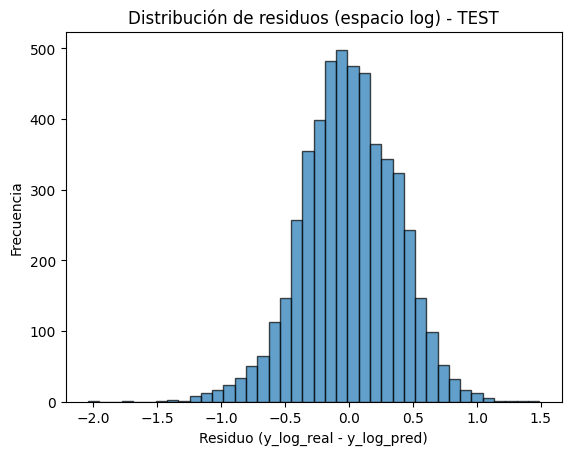

In [7]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

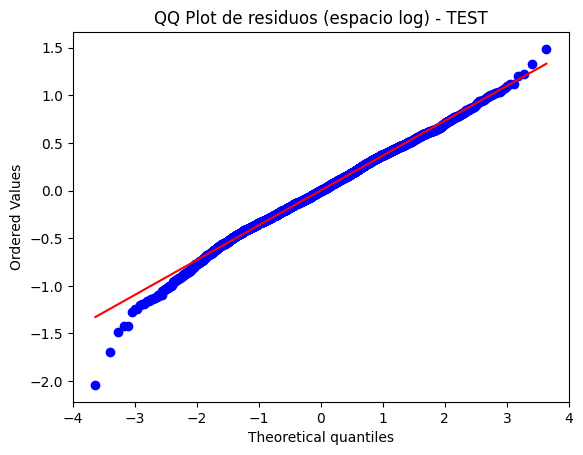

In [8]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

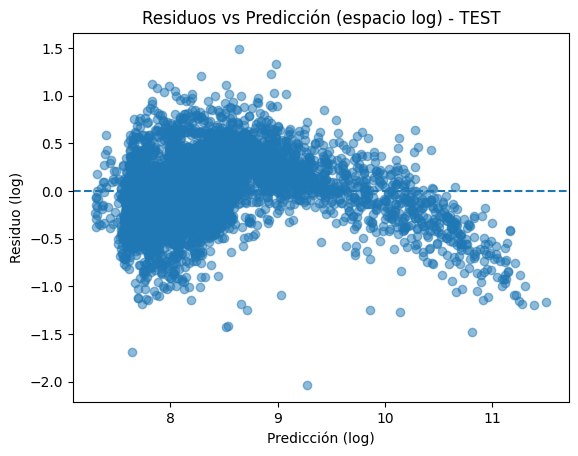

In [9]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [10]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 80.262406
LM-Test p-value: 0.000000
F-Statistic: 81.528145
F-Test p-value: 0.000000


### Segundo modelo --> Modelo Hedonico ElasticNet. 
 - Dataset sin VCR, con latitud y longitud

In [11]:
df_ENet_2 =df_vcr_c.copy() 
obj_cols = df_ENet_2.select_dtypes(include=["object"]).columns 
cols_to_drop = list(obj_cols) 
cols_to_drop.append("id") 
df_ENet_2 = df_ENet_2.drop(columns=cols_to_drop) 
df_ENet_2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [12]:
# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2
VALID_SIZE = 0.25  # fracción del conjunto de entrenamiento que se usará para validación

# Columna objetivo
target_col = "log_monto"

# Evitar fuga: nunca usar 'monto' ni 'log_monto' como features
X = df_ENet_2.drop(columns=["monto", "log_monto"])
y = df_ENet_2[target_col].values

# Guardamos índices para reconstruir métricas en espacio de precio cuando entrenamos en log
indices = np.arange(len(df_ENet_2))
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, indices, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Split de validación a partir del train
X_train, X_valid, y_train, y_valid, idx_train, idx_valid = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=VALID_SIZE, random_state=RANDOM_STATE
)

# Definición del modelo
# Escalado es crucial para ElasticNet; CV selecciona alpha y l1_ratio.
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "enet",
            ElasticNetCV(  # Busqueda automatica de hiperparametros por validacion cruzada
                l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0],  # 1=Lasso puro, 0=Ridge puro
                cv=10,  # 10-Fold CV
                random_state=RANDOM_STATE,
                n_alphas=100,
                max_iter=10000,
                # Para cada l1_ratio se genera un camino de regularizacion con 100 valores de alpha
                # Mediante la CV se elige el mejor alpha
            ),
        ),
    ]
)
# Tras encontrar todos los hiperparametros optimos, el estimador se reentrena con TODO el conjunto 
# de entrenamiento (X_train) con esos hiperparametros.

# Entrenamiento y evaluación. Se ejecuta el pipeline anterior.
model.fit(X_train, y_train)

# ---- Predicciones (log) ----
y_pred_train_log = model.predict(X_train)
y_pred_valid_log = model.predict(X_valid)
y_pred_test_log  = model.predict(X_test)

# ---- Residuos en log (test) ----
residuals_log_test = y_test - y_pred_test_log

# ---- Métricas en LOG ----
def rmse_log(y_true_log, y_pred_log):
    return float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))

r2_log_train   = r2_score(y_train, y_pred_train_log)
r2_log_valid   = r2_score(y_valid, y_pred_valid_log)
r2_log_test    = r2_score(y_test,  y_pred_test_log)

rmse_log_train = rmse_log(y_train, y_pred_train_log)
rmse_log_valid = rmse_log(y_valid, y_pred_valid_log)
rmse_log_test  = rmse_log(y_test,  y_pred_test_log)

mae_log_train = mean_absolute_error(y_train, y_pred_train_log)
mae_log_valid = mean_absolute_error(y_valid, y_pred_valid_log)
mae_log_test  = mean_absolute_error(y_test, y_pred_test_log)

# ---- Métricas en UF (precio) ----
y_true_train_price = df_ENet_1.loc[X_train.index, "monto"].to_numpy(dtype=float)
y_true_valid_price = df_ENet_1.loc[X_valid.index, "monto"].to_numpy(dtype=float)
y_true_test_price  = df_ENet_1.loc[X_test.index,  "monto"].to_numpy(dtype=float)

# Como entrenamos en log, llevamos predicciones a UF
y_pred_train_price = np.exp(y_pred_train_log)
y_pred_valid_price = np.exp(y_pred_valid_log)
y_pred_test_price  = np.exp(y_pred_test_log)

# Chequeos de consistencia
assert np.allclose(y_train, df_ENet_1.loc[X_train.index, "log_monto"].to_numpy())
assert np.allclose(y_valid, df_ENet_1.loc[X_valid.index, "log_monto"].to_numpy())
assert np.allclose(y_test,  df_ENet_1.loc[X_test.index,  "log_monto"].to_numpy())

# Métricas en precio
rmse_train = root_mean_squared_error(y_true_train_price, y_pred_train_price)
mae_train  = mean_absolute_error(y_true_train_price, y_pred_train_price)
mape_train = np.mean(np.abs((y_true_train_price - y_pred_train_price) / np.clip(y_true_train_price, 1e-9, None))) * 100

rmse_valid = root_mean_squared_error(y_true_valid_price, y_pred_valid_price)
mae_valid  = mean_absolute_error(y_true_valid_price, y_pred_valid_price)
mape_valid = np.mean(np.abs((y_true_valid_price - y_pred_valid_price) / np.clip(y_true_valid_price, 1e-9, None))) * 100

rmse_test = root_mean_squared_error(y_true_test_price, y_pred_test_price)
mae_test  = mean_absolute_error(y_true_test_price, y_pred_test_price)
mape_test = np.mean(np.abs((y_true_test_price - y_pred_test_price) / np.clip(y_true_test_price, 1e-9, None))) * 100

print("=== ElasticNet Hedónico ===")
print(">> Métricas en LOG")
print(f"Train: R^2={r2_log_train:.4f} | RMSE_log={rmse_log_train:.4f} | MAE={mae_log_train:,.4f}")
print(f"Valid: R^2={r2_log_valid:.4f} | RMSE_log={rmse_log_valid:.4f} | MAE={mae_log_valid:,.4f}")
print(f"Test : R^2={r2_log_test:.4f}  | RMSE_log={rmse_log_test:.4f} | MAE={mae_log_test:,.4f}")

print(">> Métricas en UF (precio)")
print(f"Train: RMSE={rmse_train:,.2f} | MAE={mae_train:,.2f} | MAPE={mape_train:.2f}%")
print(f"Valid: RMSE={rmse_valid:,.2f} | MAE={mae_valid:,.2f} | MAPE={mape_valid:.2f}%")
print(f"Test : RMSE={rmse_test:,.2f}  | MAE={mae_test:,.2f}  | MAPE={mape_test:.2f}%")

# Coeficientes
enet: ElasticNetCV = model.named_steps["enet"]
coef = enet.coef_
feat_names = X.columns
coef_df = (
    pd.DataFrame({"feature": feat_names, "coef": coef})
    .assign(abs_coef=lambda d: d.coef.abs())
    .sort_values("abs_coef", ascending=False)
)
print("\nTop 20 coeficientes por |coef| (estandarizados):")
print(coef_df.head(20).to_string(index=False))

# ---- Extra: resumen de CV (log) y datos para el gráfico de la curva de validación ----
enet: ElasticNetCV = model.named_steps["enet"]

# Identificar índice del mejor l1_ratio en la grilla usada
l1_candidates = np.atleast_1d(enet.l1_ratio).astype(float)
best_l1 = float(enet.l1_ratio_)
l1_idx = int(np.argmin(np.abs(l1_candidates - best_l1)))

# Paths de alphas y MSE (log) para ese l1_ratio
alphas_path = enet.alphas_[l1_idx]               # shape: (n_alphas,)
mse_path    = enet.mse_path_[l1_idx]             # shape: (n_alphas, n_folds)
mean_mse    = mse_path.mean(axis=1)
std_mse     = mse_path.std(axis=1)

# Ubicación del mejor alpha
best_alpha = float(enet.alpha_)
best_alpha_idx = int(np.argmin(np.abs(alphas_path - best_alpha)))
cv_rmse_log_best = float(np.sqrt(mean_mse[best_alpha_idx]))

print("\n>> CV (10-fold) en LOG")
print(f"l1_ratio*={best_l1} | alpha*={best_alpha:.6f} | RMSE_log_CV={cv_rmse_log_best:.4f}")

# Guardar datos para el gráfico (siguiente celda)
enet_cv_path = {
    "alphas": alphas_path,
    "mean_mse_log": mean_mse,
    "std_mse_log": std_mse,
    "best_alpha": best_alpha,
}


=== ElasticNet Hedónico ===
>> Métricas en LOG
Train: R^2=0.8667 | RMSE_log=0.3015 | MAE=0.2316
Valid: R^2=0.8666 | RMSE_log=0.3053 | MAE=0.2337
Test : R^2=0.8720  | RMSE_log=0.2998 | MAE=0.2324
>> Métricas en UF (precio)
Train: RMSE=4,148.11 | MAE=1,726.68 | MAPE=24.40%
Valid: RMSE=3,967.09 | MAE=1,757.26 | MAPE=24.44%
Test : RMSE=3,829.22  | MAE=1,718.53  | MAPE=24.31%

Top 20 coeficientes por |coef| (estandarizados):
             feature      coef  abs_coef
        superficie_t  0.333194  0.333194
            longitud  0.240067  0.240067
               banos  0.111052  0.111052
             bodegas  0.081850  0.081850
             latitud  0.080591  0.080591
         dormitorios  0.068491  0.068491
      banos_faltante  0.046085  0.046085
     estacionamiento  0.041940  0.041940
   flag_Monoambiente -0.020787  0.020787
          antiguedad -0.019189  0.019189
                Or_E  0.013345  0.013345
   flag_Departamento  0.008429  0.008429
 antiguedad_faltante -0.007024  0.007024
  

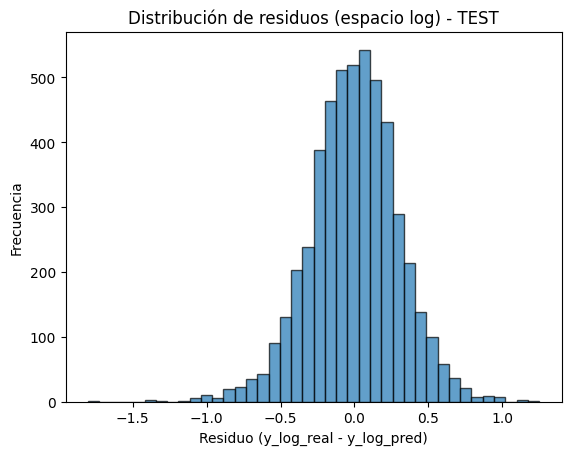

In [13]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

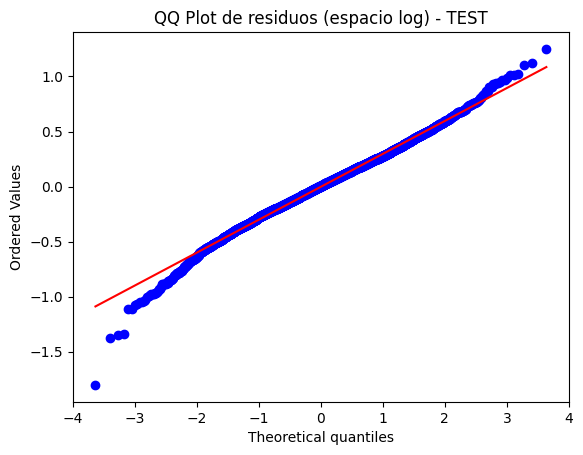

In [14]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

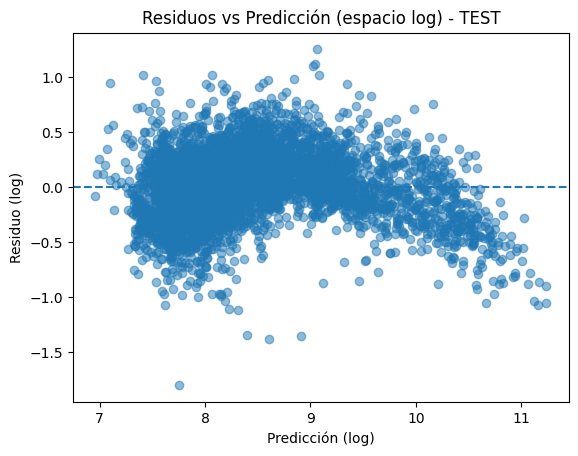

In [15]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

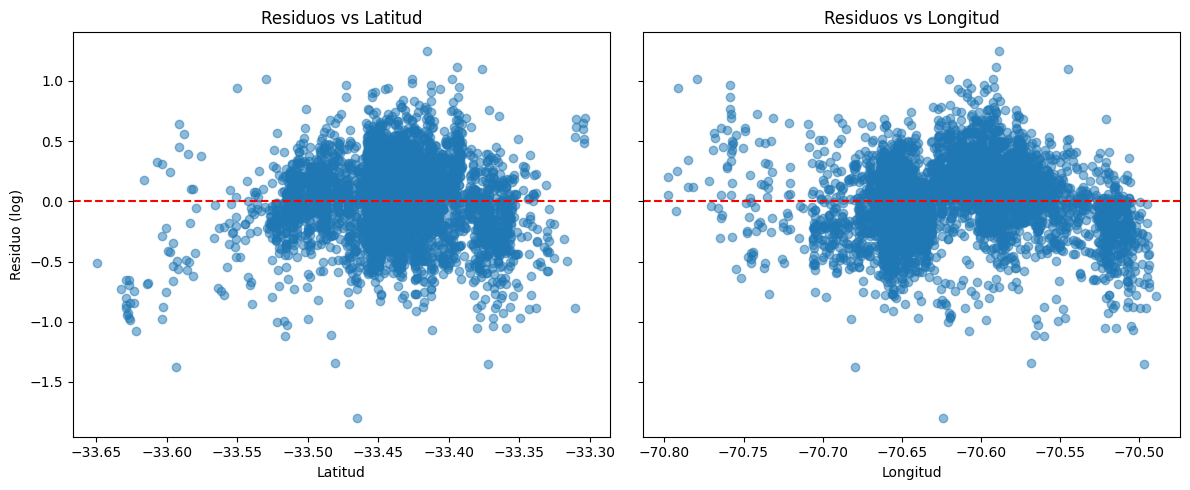

In [19]:
lat_idx = feat_names.get_loc("latitud")
lon_idx = feat_names.get_loc("longitud")

lat_vals = X_test.iloc[:, lat_idx].to_numpy()
lon_vals = X_test.iloc[:, lon_idx].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].scatter(lat_vals, residuals_log_test, alpha=0.5)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Latitud")
axes[0].set_ylabel("Residuo (log)")
axes[0].set_title("Residuos vs Latitud")

axes[1].scatter(lon_vals, residuals_log_test, alpha=0.5)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_xlabel("Longitud")
axes[1].set_title("Residuos vs Longitud")

plt.tight_layout()
plt.show()


In [20]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log (puedes añadir más)
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 43.966903
LM-Test p-value: 0.000000
F-Statistic: 44.336006
F-Test p-value: 0.000000


### Tercer modelo --> Modelo Hedonico ElasticNet. 
 - Dataset completo
 - Se imputan los datos faltantes en las columnas de VCR expandidas. Ver lógica en documentación.

In [21]:
df_ENet_3 =df_vcr_e.copy()
obj_cols = df_ENet_3.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_ENet_3 = df_ENet_3.drop(columns=cols_to_drop)
df_ENet_3.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 181 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    monto                         int64  
 1    superficie_t                  float64
 2    dormitorios                   int64  
 3    dormitorios_faltante          int64  
 4    banos                         int64  
 5    banos_faltante                int64  
 6    antiguedad                    int64  
 7    antiguedad_faltante           int64  
 8    Or_N                          int64  
 9    Or_S                          int64  
 10   Or_E                          int64  
 11   Or_O                          int64  
 12   Or_Faltante                   int64  
 13   terraza                       float64
 14   estacionamiento               int64  
 15   bodegas                       int64  
 16   flag_Departamento             int64  
 17   flag_Multinivel               int64  
 18   flag_Semi

In [22]:
# %% Configuración (
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# %% Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out



df_ENet_3_imp = impute_vcr_semantic(df_ENet_3)
df_ENet_3_imp.info()  


Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [23]:
# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2
VALID_SIZE = 0.25  # fracción del conjunto de entrenamiento que se usará para validación

# Columna objetivo
target_col = "log_monto"

# Evitar fuga: nunca usar 'monto' ni 'log_monto' como features
X = df_ENet_3_imp.drop(columns=["monto", "log_monto"])
y = df_ENet_3_imp[target_col].values

# Guardamos índices para reconstruir métricas en espacio de precio cuando entrenamos en log
indices = np.arange(len(df_ENet_3_imp))
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, indices, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Split de validación a partir del train
X_train, X_valid, y_train, y_valid, idx_train, idx_valid = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=VALID_SIZE, random_state=RANDOM_STATE
)

# Definición del modelo
# Escalado es crucial para ElasticNet; CV selecciona alpha y l1_ratio.
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "enet",
            ElasticNetCV(  # Busqueda automatica de hiperparametros por validacion cruzada
                l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0],  # 1=Lasso puro, 0=Ridge puro
                cv=10,  # 10-Fold CV
                random_state=RANDOM_STATE,
                n_alphas=100,
                max_iter=10000,
                # Para cada l1_ratio se genera un camino de regularizacion con 100 valores de alpha
                # Mediante la CV se elige el mejor alpha
            ),
        ),
    ]
)
# Tras encontrar todos los hiperparametros optimos, el estimador se reentrena con TODO el conjunto 
# de entrenamiento (X_train) con esos hiperparametros.

# Entrenamiento y evaluación. Se ejecuta el pipeline anterior.
model.fit(X_train, y_train)

# ---- Predicciones (log) ----
y_pred_train_log = model.predict(X_train)
y_pred_valid_log = model.predict(X_valid)
y_pred_test_log  = model.predict(X_test)

# ---- Residuos en log (test) ----
residuals_log_test = y_test - y_pred_test_log

# ---- Métricas en LOG ----
def rmse_log(y_true_log, y_pred_log):
    return float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))

r2_log_train   = r2_score(y_train, y_pred_train_log)
r2_log_valid   = r2_score(y_valid, y_pred_valid_log)
r2_log_test    = r2_score(y_test,  y_pred_test_log)

rmse_log_train = rmse_log(y_train, y_pred_train_log)
rmse_log_valid = rmse_log(y_valid, y_pred_valid_log)
rmse_log_test  = rmse_log(y_test,  y_pred_test_log)

mae_log_train = mean_absolute_error(y_train, y_pred_train_log)
mae_log_valid = mean_absolute_error(y_valid, y_pred_valid_log)
mae_log_test  = mean_absolute_error(y_test, y_pred_test_log)

# ---- Métricas en UF (precio) ----
y_true_train_price = df_ENet_1.loc[X_train.index, "monto"].to_numpy(dtype=float)
y_true_valid_price = df_ENet_1.loc[X_valid.index, "monto"].to_numpy(dtype=float)
y_true_test_price  = df_ENet_1.loc[X_test.index,  "monto"].to_numpy(dtype=float)

# Como entrenamos en log, llevamos predicciones a UF
y_pred_train_price = np.exp(y_pred_train_log)
y_pred_valid_price = np.exp(y_pred_valid_log)
y_pred_test_price  = np.exp(y_pred_test_log)

# Chequeos de consistencia
assert np.allclose(y_train, df_ENet_1.loc[X_train.index, "log_monto"].to_numpy())
assert np.allclose(y_valid, df_ENet_1.loc[X_valid.index, "log_monto"].to_numpy())
assert np.allclose(y_test,  df_ENet_1.loc[X_test.index,  "log_monto"].to_numpy())

# Métricas en precio
rmse_train = root_mean_squared_error(y_true_train_price, y_pred_train_price)
mae_train  = mean_absolute_error(y_true_train_price, y_pred_train_price)
mape_train = np.mean(np.abs((y_true_train_price - y_pred_train_price) / np.clip(y_true_train_price, 1e-9, None))) * 100

rmse_valid = root_mean_squared_error(y_true_valid_price, y_pred_valid_price)
mae_valid  = mean_absolute_error(y_true_valid_price, y_pred_valid_price)
mape_valid = np.mean(np.abs((y_true_valid_price - y_pred_valid_price) / np.clip(y_true_valid_price, 1e-9, None))) * 100

rmse_test = root_mean_squared_error(y_true_test_price, y_pred_test_price)
mae_test  = mean_absolute_error(y_true_test_price, y_pred_test_price)
mape_test = np.mean(np.abs((y_true_test_price - y_pred_test_price) / np.clip(y_true_test_price, 1e-9, None))) * 100

print("=== ElasticNet Hedónico (control) ===")
print(">> Métricas en LOG")
print(f"Train: R^2={r2_log_train:.4f} | RMSE_log={rmse_log_train:.4f} | MAE={mae_log_train:,.4f}")
print(f"Valid: R^2={r2_log_valid:.4f} | RMSE_log={rmse_log_valid:.4f} | MAE={mae_log_valid:,.4f}")
print(f"Test : R^2={r2_log_test:.4f}  | RMSE_log={rmse_log_test:.4f} | MAE={mae_log_test:,.4f}")

print(">> Métricas en UF (precio)")
print(f"Train: RMSE={rmse_train:,.2f} | MAE={mae_train:,.2f} | MAPE={mape_train:.2f}%")
print(f"Valid: RMSE={rmse_valid:,.2f} | MAE={mae_valid:,.2f} | MAPE={mape_valid:.2f}%")
print(f"Test : RMSE={rmse_test:,.2f}  | MAE={mae_test:,.2f}  | MAPE={mape_test:.2f}%")

# Coeficientes
enet: ElasticNetCV = model.named_steps["enet"]
coef = enet.coef_
feat_names = X.columns
coef_df = (
    pd.DataFrame({"feature": feat_names, "coef": coef})
    .assign(abs_coef=lambda d: d.coef.abs())
    .sort_values("abs_coef", ascending=False)
)
print("\nTop 20 coeficientes por |coef| (estandarizados):")
print(coef_df.head(20).to_string(index=False))

# ---- Extra: resumen de CV (log) y datos para el gráfico de la curva de validación ----
enet: ElasticNetCV = model.named_steps["enet"]

# Identificar índice del mejor l1_ratio en la grilla usada
l1_candidates = np.atleast_1d(enet.l1_ratio).astype(float)
best_l1 = float(enet.l1_ratio_)
l1_idx = int(np.argmin(np.abs(l1_candidates - best_l1)))

# Paths de alphas y MSE (log) para ese l1_ratio
alphas_path = enet.alphas_[l1_idx]               # shape: (n_alphas,)
mse_path    = enet.mse_path_[l1_idx]             # shape: (n_alphas, n_folds)
mean_mse    = mse_path.mean(axis=1)
std_mse     = mse_path.std(axis=1)

# Ubicación del mejor alpha
best_alpha = float(enet.alpha_)
best_alpha_idx = int(np.argmin(np.abs(alphas_path - best_alpha)))
cv_rmse_log_best = float(np.sqrt(mean_mse[best_alpha_idx]))

print("\n>> CV (10-fold) en LOG")
print(f"l1_ratio*={best_l1} | alpha*={best_alpha:.6f} | RMSE_log_CV={cv_rmse_log_best:.4f}")

# Guardar datos para el gráfico (siguiente celda)
enet_cv_path = {
    "alphas": alphas_path,
    "mean_mse_log": mean_mse,
    "std_mse_log": std_mse,
    "best_alpha": best_alpha,
}


=== ElasticNet Hedónico (control) ===
>> Métricas en LOG
Train: R^2=0.9112 | RMSE_log=0.2461 | MAE=0.1839
Valid: R^2=0.9108 | RMSE_log=0.2495 | MAE=0.1861
Test : R^2=0.9134  | RMSE_log=0.2465 | MAE=0.1877
>> Métricas en UF (precio)
Train: RMSE=2,760.07 | MAE=1,267.74 | MAPE=19.08%
Valid: RMSE=2,743.94 | MAE=1,303.50 | MAPE=19.31%
Test : RMSE=2,637.22  | MAE=1,275.31  | MAPE=19.33%

Top 20 coeficientes por |coef| (estandarizados):
                     feature      coef  abs_coef
                superficie_t  0.326135  0.326135
                    longitud  0.163216  0.163216
 food_and_drink_stores_dim00 -0.112970  0.112970
                     latitud  0.097711  0.097711
               medical_dim00  0.092100  0.092100
                       banos  0.085599  0.085599
     sport_and_leisure_dim00  0.071621  0.071621
                 dormitorios  0.070119  0.070119
arts_and_entertainment_dim00 -0.064095  0.064095
        food_and_drink_dim00  0.058865  0.058865
                     bodega

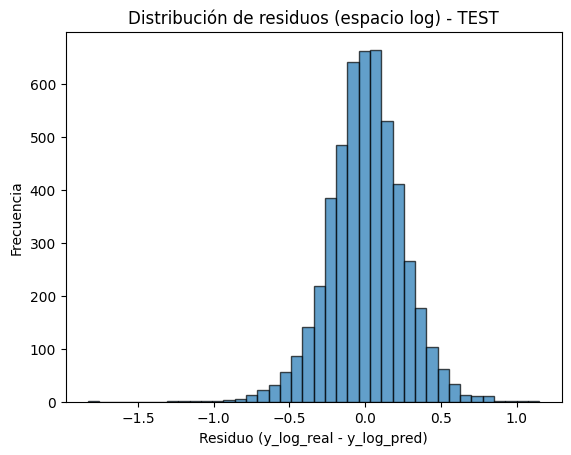

In [24]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

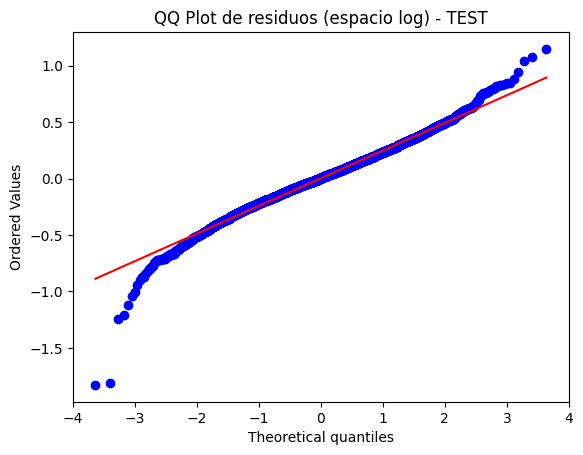

In [25]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

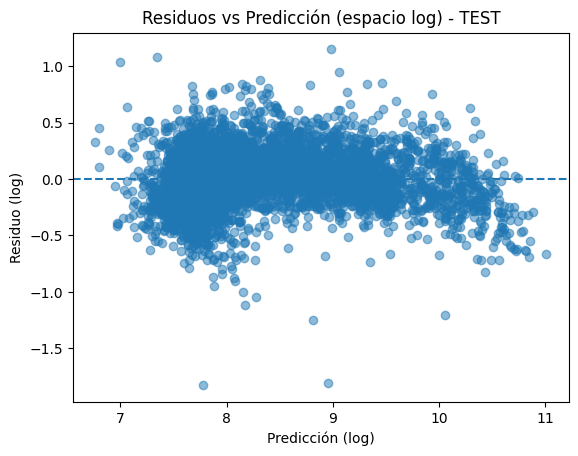

In [26]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

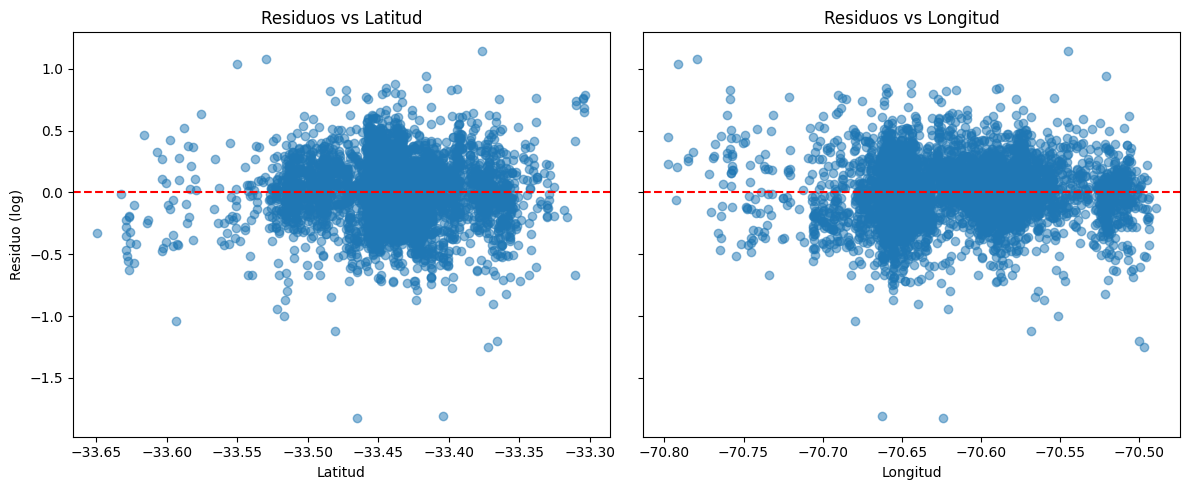

In [27]:
lat_idx = feat_names.get_loc("latitud")
lon_idx = feat_names.get_loc("longitud")

lat_vals = X_test.iloc[:, lat_idx].to_numpy()
lon_vals = X_test.iloc[:, lon_idx].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].scatter(lat_vals, residuals_log_test, alpha=0.5)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Latitud")
axes[0].set_ylabel("Residuo (log)")
axes[0].set_title("Residuos vs Latitud")

axes[1].scatter(lon_vals, residuals_log_test, alpha=0.5)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_xlabel("Longitud")
axes[1].set_title("Residuos vs Longitud")

plt.tight_layout()
plt.show()


In [28]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log (puedes añadir más)
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 0.001048
LM-Test p-value: 0.974177
F-Statistic: 0.001047
F-Test p-value: 0.974184


### Resultados ElasticNet (con diferentes niveles de información georreferencial)

| Modelo                               | Conjunto | R² (log) | RMSE_log | MAE_log | RMSE ($) | MAE ($) | MAPE (%) |
|--------------------------------------|----------|:--------:|:--------:|:-------:|---------:|--------:|---------:|
| **1) Base (solo estructural)**       | Train    |  0.8031  |  0.3676  | 0.2886  | 5,184.06 | 2,135.42|   30.68  |
|                                      | Test     |  0.8092  |  0.3659  | 0.2887  | 5,031.14 | 2,156.48|   30.60  |
| **2) + Latitud/Longitud**            | Train    |  0.8668  |  0.3024  | 0.2321  | 4,091.16 | 1,732.43|   24.44  |
|                                      | Test     |  0.8719  |  0.2998  | 0.2326  | 3,815.32 | 1,717.30|   24.36  |
| **3) + VCR (contexto urbano)**       | Train    |  0.9112  |  0.2468  | 0.1843  | 2,754.59 | 1,276.97|   19.15  |
|                                      | Test     |  0.9145  |  0.2450  | 0.1874  | 2,632.45 | 1,273.44|   19.24  |



### Resultados ElasticNet (despues de agregar resultados en validacion)

| Modelo                               | Conjunto | R² (log) | RMSE_log | MAE_log | RMSE ($) | MAE ($) | MAPE (%) |
|--------------------------------------|----------|:--------:|:--------:|:-------:|---------:|--------:|---------:|
| **1) Base (solo estructural)**       | Train    |  0.8032  |  0.3664  | 0.2880  | 5,169.63 | 2,124.53 |   30.60  |
|                                      | Valid    |  0.8028  |  0.3711  | 0.2905  | 5,185.16 | 2,161.54 |   30.58  |
|                                      | Test     |  0.8094  |  0.3657  | 0.2886  | 5,008.52 | 2,152.17 |   30.50  |
| **2) + Coord (coordenadas)**         | Train    |  0.8667  |  0.3015  | 0.2316  | 4,148.11 | 1,726.68 |   24.40  |
|                                      | Valid    |  0.8666  |  0.3053  | 0.2337  | 3,967.09 | 1,757.26 |   24.44  |
|                                      | Test     |  0.8720  |  0.2998  | 0.2324  | 3,829.22 | 1,718.53 |   24.31  |
| **3) + VCR (contexto urbano)**       | Train    |  0.9112  |  0.2461  | 0.1839  | 2,760.07 | 1,267.74 |   19.08  |
|                                      | Valid    |  0.9108  |  0.2495  | 0.1861  | 2,743.94 | 1,303.50 |   19.31  |
|                                      | Test     |  0.9134  |  0.2465  | 0.1877  | 2,637.22 | 1,275.31 |   19.33  |


### Comparación de resultados entre modelos

Los resultados muestran un progreso claro y consistente al incorporar distintos niveles de información georreferencial en el modelo hedónico. El modelo base, construido únicamente con atributos estructurales de las viviendas, alcanzó un R² de 0.81 en logaritmos, con errores en el espacio de precios reales de RMSE = 5,009, MAE = 2,152 y un MAPE de 30.5%, lo que evidencia una capacidad predictiva inicial relativamente limitada. Al incluir las coordenadas (Coord), el desempeño mejora de manera significativa: el R² aumenta a 0.87 y los errores se reducen notablemente (RMSE = 3,829; MAE = 1,719; MAPE = 24.3%), confirmando la importancia de la ubicación geográfica aun en su forma más simple. Finalmente, la incorporación completa de los vectores de características de referencia (VCR), que sintetizan métricas del contexto urbano y la presencia de diversos puntos de interés, produce un salto sustancial en la calidad del modelo: R² = 0.91, RMSE = 2,637, MAE = 1,275 y MAPE = 19.3%. Esta mejora refleja una reducción drástica en los errores absolutos y relativos, demostrando de forma cuantitativa el valor agregado de la información geoespacial en la predicción de precios inmobiliarios. Cabe destacar que las métricas de entrenamiento, validación y prueba se mantienen cercanas en todos los modelos, lo que sugiere una buena capacidad de generalización y ausencia de sobreajuste evidente.
